# Literature analysis for the WOA chapter: Ten Years of Self-organisation with Aggregate Computing: A Reflection Under the Lenses ofMulti-Agent Systems Engineering
This repository contains the code to reproduce tha charts presented in the chapter of the WOA book for the 25th year of the conference.
From this analysis, we can see the main topics related to aggregate computing (which are self-organisation, spatial computing, learning, coordination) are discussed over the years consistently. This analysis highlight also the topics which we used to structure the chapter.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import litstudy
import json
import seaborn

from collections import namedtuple
from wordcloud import wordcloud

seaborn.set_style("whitegrid")
# Options for plots
plt.rcParams['figure.figsize'] = (10, 6)
## font size
plt.rcParams.update({'font.size': 20})
BibData = namedtuple("BibData", ["identifier", "title", "authors", "abstract", "publication_year"])
Author = namedtuple("Author", ["name"])

## Data Loading
In data.tsv we have the data given from the book chapter editors, which consist of the following columns:
- Authors: The authors of the paper
- Title: The title of the paper
- Abstract: The abstract of the paper
- Year: The year of the paper
- Discussed: If the paper was discussed in the chapter (filtered using the keywords `spatial`, `learning`, `autonomic`, `self-*`, `coordination`, `mult-agent`, `self-*` and with a manual review of the abstract, verifying if the paper was related to the topics of the chapter)

In [36]:
woa_papers = pd.read_csv("data.tsv", sep='\t')

In [37]:
woa_papers = woa_papers[woa_papers['Discussed'] == 1.0]

In [38]:
woa_papers.head()

,Discussed,Authors,Title,Year,Abstract
0,1.0,Cherchi G.; Manconi A.; Vargiu E.; Deledda D.,"Text categorization using a Personalized, Adap...",2005,"In this paper, a multiagent system for support..."
1,1.0,Morreale V.; Bonura S.; Centineo F.; Rossi A.;...,PRACTIONIST: Implementing PRACTIcal reasONIng ...,2005,One of the best known approaches to the develo...
7,1.0,Bandini S.; Manzoni S.; Redaelli S.,Towards the interpretation of emergent spatial...,2005,In this paper we present the preliminary resul...
11,1.0,Mascardi V.; Demergasso D.; Ancona D.,Languages for programming BDI-style agents: An...,2005,The notion of an intelligent agent as an entit...
12,1.0,Gardelli L.; Viroli M.; Omicini A.,On the role of simulation in the engineering o...,2005,The intrinsic complexity of self-organising mu...


This code convert the data to a format that can be used by the litstudy library, which is a list of BibData objects.
This object has the following fields:
- identifier: The identifier of the paper (title in this case, but it could be the DOI)
- title: The title of the paper 
- authors: A list of Author objects, which have a single field, name
- abstract: The abstract of the paper
- publication_year: The year of the paper

In [39]:
lit_study_compatible = []
for (id, element) in woa_papers.iterrows():
    authors = element['Authors'].split(';')
    authors = [Author(authors[i]) for i in range(len(authors))]
    data = BibData(element['Title'], element['Title'], authors, element['Abstract'], element['Year'])
    lit_study_compatible.append(data)
"Papers in the literature analysis:", len(lit_study_compatible)

('Papers in the literature analysis:', 58)

In order to perform the analysis, we need to filter the words that are not relevant to the analysis. This is done by loading the words_filter.json file, which contains a list of words that are not relevant to the analysis (i.e., common words like "application", "system", "model", etc).

In [40]:
# load word filter
with open("words_filter.json") as f:
    words_to_filter = json.load(f)

# Analysis
The analysis is performed in the following steps:
1. Build the corpus: This step creates a corpus from the data, removing the words that are not relevant and using n-grams to group similar words.
2. Plot the year histogram: This step plots the number of papers per year.
3. Plot the author histogram: This step plots the number of papers per author.
4. Compute the word distribution: This step computes the distribution of words in the corpus.
5. Plot the word distribution: This step plots the distribution of words in the corpus.
6. Compute the topic model: This step computes the topic model using NMF.
7. Plot the topic clouds: This step plots the topic clouds.

## Build the corpus

In [41]:
corpus = litstudy.build_corpus(
    lit_study_compatible, 
    ngram_threshold=0.8, 
    remove_words=words_to_filter,
)

## Plot the year histogram 
number of papers per year of self-organisation papers

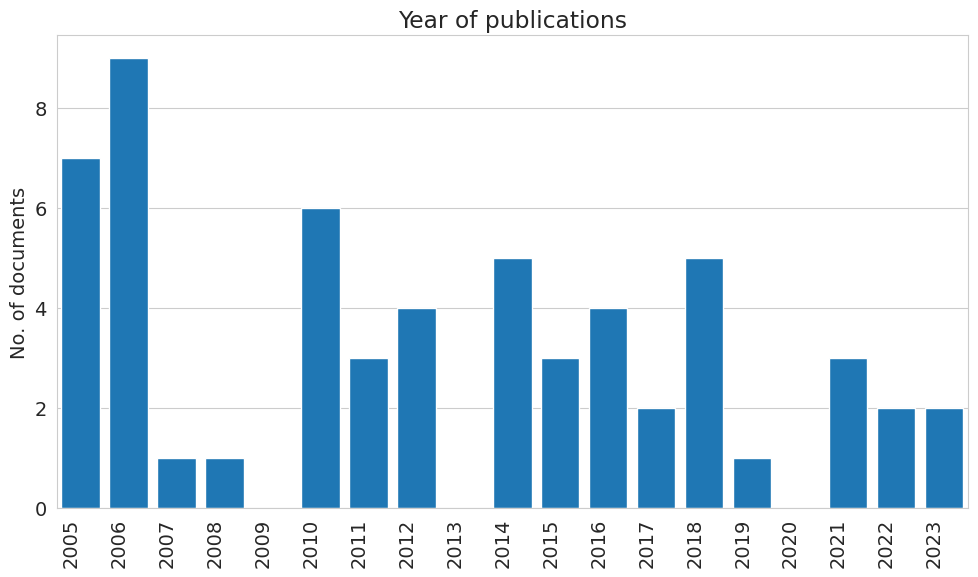

In [42]:
litstudy.plot_year_histogram(lit_study_compatible, vertical=True)
plt.tight_layout()
plt.savefig("images/year_histogram.pdf")

## Plot the author histogram
Number of papers per author

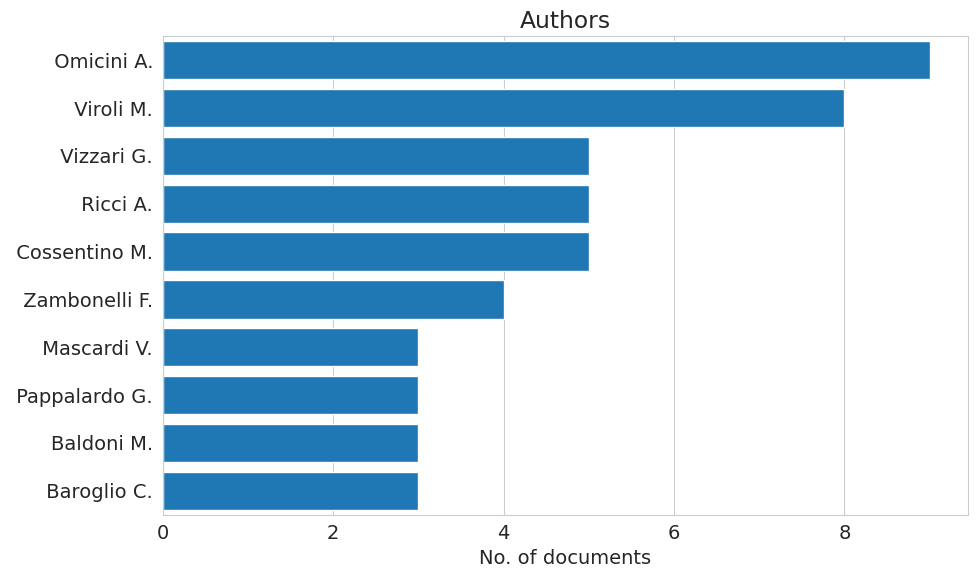

In [43]:
litstudy.plot_author_histogram(lit_study_compatible, limit=10, vertical=False)
plt.tight_layout()
plt.savefig("images/authors.pdf")

## Compute (and plotting) the word distribution 
Namely, how many times each word appears in the corpus 

In [44]:
litstudy.compute_word_distribution(corpus, limit=1000)

,count
model,29
adaptive,22
environment,21
multi,17
coordination,17
...,...
example,5
field,5
decisions,5
runtime,5


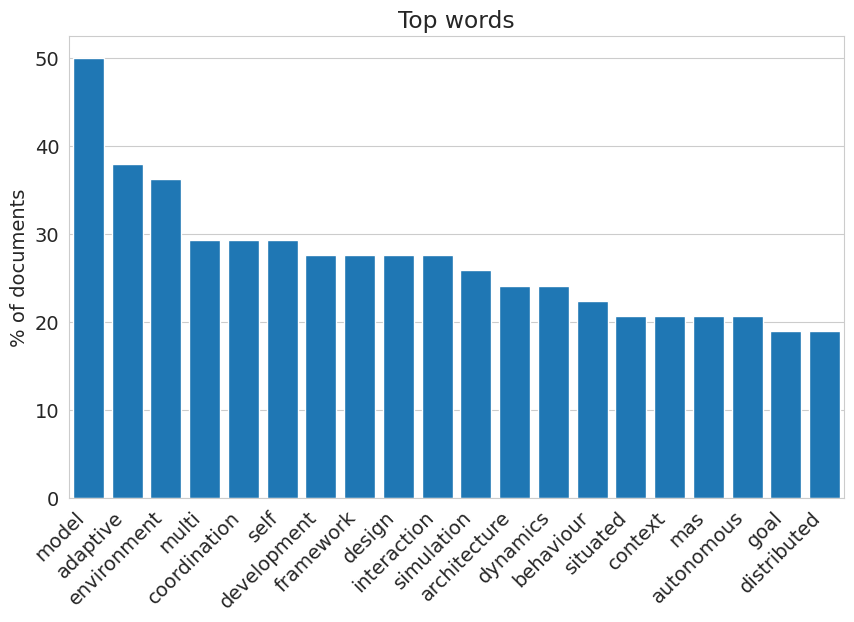

In [45]:
litstudy.plot_word_distribution(corpus, limit=20, title="Top words", vertical=True, label_rotation=45);
plt.savefig("images/top_words.pdf")

## Compute (and plot) the topic model 
Namely, the topics that are present in the corpus using NMF

In [46]:
num_topics = 4
topic_model = litstudy.train_nmf_model(corpus, num_topics, seed=142)

In [47]:
for i in range(num_topics):
    print(f'Topic {i+1}:', topic_model.best_tokens_for_topic(i))

Topic 1: ['pervasive', 'ecosystem', 'networks', 'autonomous', 'programming']
Topic 2: ['coordination', 'tuple', 'tucson', 'interaction', 'model']
Topic 3: ['self', 'algorithm', 'organising', 'process', 'basic']
Topic 4: ['goal', 'logic', 'bdi', 'learning', 'actions']


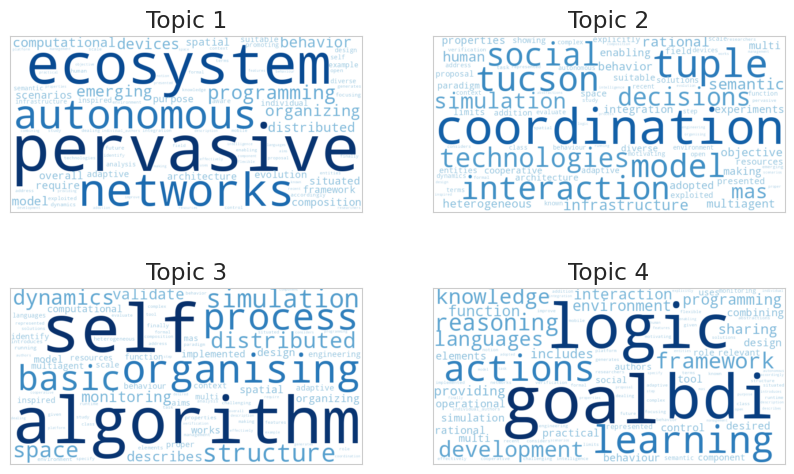

In [48]:
litstudy.plot_topic_clouds(topic_model, ncols=2)
plt.rcParams.update({'font.size': 14})
plt.savefig("images/topic_clouds.pdf")

## Plot the word cloud
Namely, the most frequent words in the corpus. This is a visual representation of the word distribution.
The bigger the word, the more frequent it is in the corpus.

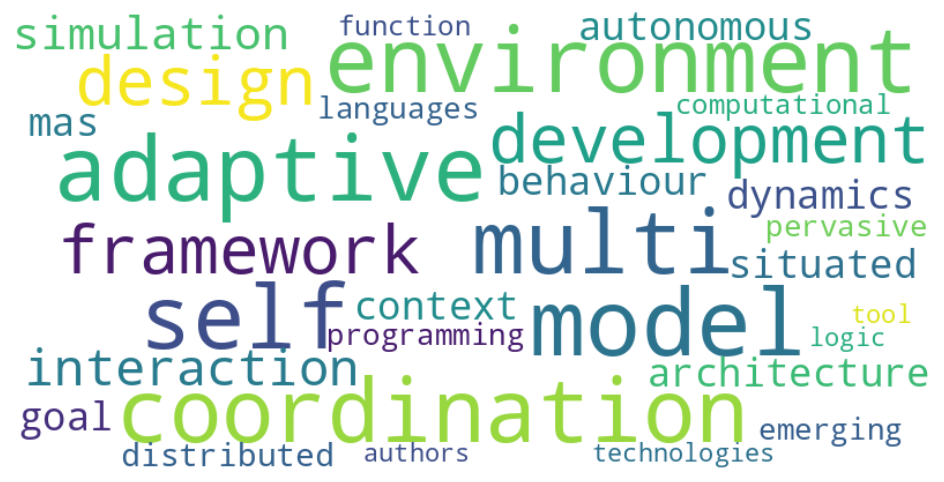

In [49]:
wc = wordcloud.WordCloud(
    prefer_horizontal=True,
    background_color='white',
    max_font_size=40,
    scale=2,
    relative_scaling=0.1,
)

words = litstudy.compute_word_distribution(corpus, limit=30)

frequencies = {}
for word, freq in words.iterrows():
    frequencies[word] = freq[0]
im = wc.generate_from_frequencies(frequencies)
plt.figure(figsize=(54, 6))
plt.imshow(im, interpolation='bilinear')
plt.axis('off')
plt.savefig("images/wordcloud.pdf")


In [287]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
zeroshot_topic_list = ["Multi-agent", "Pervasive Computing", "Spatial", "Reinforcement Learning", "Programming Agents", "Coordination"]

# We fit our model using the zero-shot topics
# and we define a minimum similarity. For each document,
# if the similarity does not exceed that value, it will be used
# for clustering instead.
topic_model = BERTopic(
    embedding_model="thenlper/gte-small", 
    min_topic_size=3,
    zeroshot_topic_list=zeroshot_topic_list,
    zeroshot_min_similarity=.85,
    representation_model=KeyBERTInspired()
)

docs = []

for paper in lit_study_compatible:
    docs.append(paper.title + " " + paper.abstract)
topics, probs = topic_model.fit_transform(docs)

In [281]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,16,-1_robots_robot_dynamics_autonomous,"[robots, robot, dynamics, autonomous, computat...",[Agent-based Spatial Model Coupling Using a Co...
1,0,13,Multi-agent,"[multiagent, simulations, simulation, agents, ...",[MERCURIO: An interaction-oriented framework f...
2,1,6,Pervasive Computing,"[pervasive, distributed, computational, comput...",[Towards a comprehensive approach to spontaneo...
3,2,4,Reinforcement Learning,"[reinforcement, simulation, learning, openai, ...",[A deep reinforcement learning approach to ada...
4,3,15,Programming Agents,"[reasoning, agent, programming, agents, logic,...",[Overview of a formal semantics for the JADEL ...
5,4,4,Coordination,"[coordination, interaction, negotiation, agent...",[Multi-paradigm coordination for MAS: Integrat...


In [301]:
topic_list_names = topic_model.get_topic_info().Name.to_list()

In [308]:
topic_list_names

['-1_robots_robot_dynamics_autonomous',
 'Multi-agent',
 'Pervasive Computing',
 'Reinforcement Learning',
 'Programming Agents',
 'Coordination']

In [311]:
def topicMap(topic_id):
    if(topic_id >= 0):
        return topic_list_names[topic_id + 1]
    else:
        return "Self-*, Autonomic & Autonomous Systems"

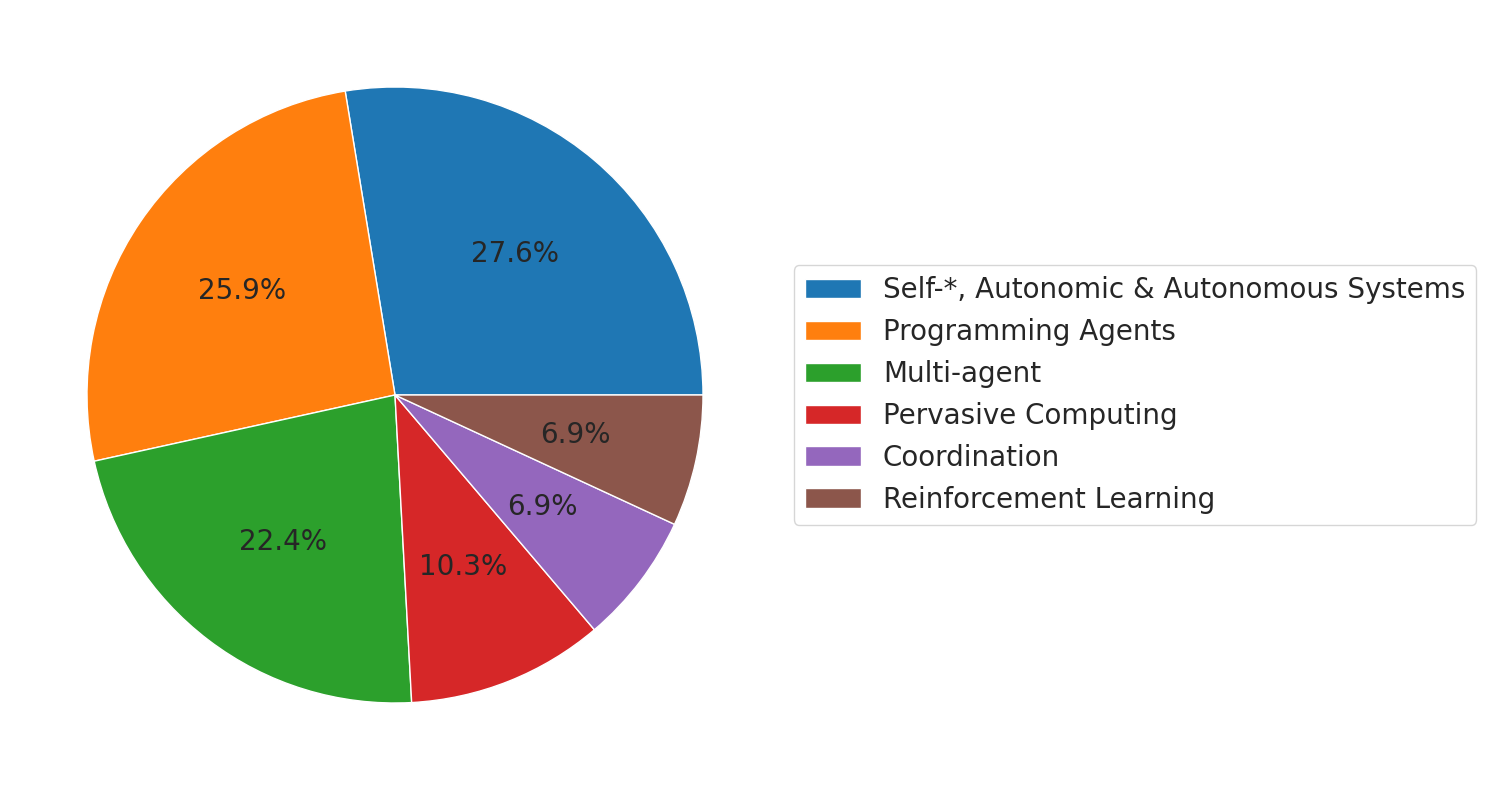

In [332]:
plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = (25, 10)
# pie chart based on the topics
topics_render = [topicMap(topic) for topic in topics]
topics_series = pd.Series(topics_render)
topics_series = topics_series.value_counts()
topics_series.plot.pie(autopct="%.1f%%", labels = ["" for i in topics_series.index])
# remove axis
plt.axis('off')
# put name as legend
plt.legend(topics_series.index, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
# remove name of the pie chart

plt.savefig("images/topics_pie.pdf")